In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import itertools
%matplotlib inline
np.random.seed(0)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
import matplotlib.patches as patches

from STM import STM
from utils import * 

In [2]:
%load_ext autoreload
%autoreload 2

## Dummy Dataset

Create 4 source subjects, each of size m x D (feature space). Here let D = 2 and m = 50, with 3 classes. Each subject represents a domain (Q: should we create the data a little differently?).

In [6]:
def make_data(class1, class2, class3):
    df1 = pd.DataFrame(class1, columns=['d1', 'd2'])
    df1['label'] = [0] * len(df1)
    df2 = pd.DataFrame(class2, columns=['d1', 'd2'])
    df2['label'] = [1] * len(df2)
    df3 = pd.DataFrame(class3, columns=['d1', 'd2'])
    df3['label'] = [2] * len(df3)
    df = pd.concat([df1, df2, df3], ignore_index=True)
    return df

def rot_matrix(angle):
    return np.array(
        [[np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]])

A1 = np.random.multivariate_normal((5, 5), [[1, 0], [0, 0.25]], 100)
A2 = np.random.multivariate_normal((5, -8), [[0.1, 0], [0, 5]], 100)
A3 = np.random.multivariate_normal((-5, -8), [[0.5, 0.8], [0.8, 3]], 100)

A = make_data(A1, A2, A3)

theta = np.pi/2
B = (rot_matrix(theta) @ A[['d1', 'd2']].T).T
B.columns = ['d1', 'd2']
B['label'] = A['label']

theta = math.radians(60)
C = (rot_matrix(theta) @ A[['d1', 'd2']].T).T
C.columns = ['d1', 'd2']
C['label'] = A['label']

theta = math.radians(120)
D = (rot_matrix(theta) @ A[['d1', 'd2']].T).T
D.columns = ['d1', 'd2']
D['label'] = A['label']

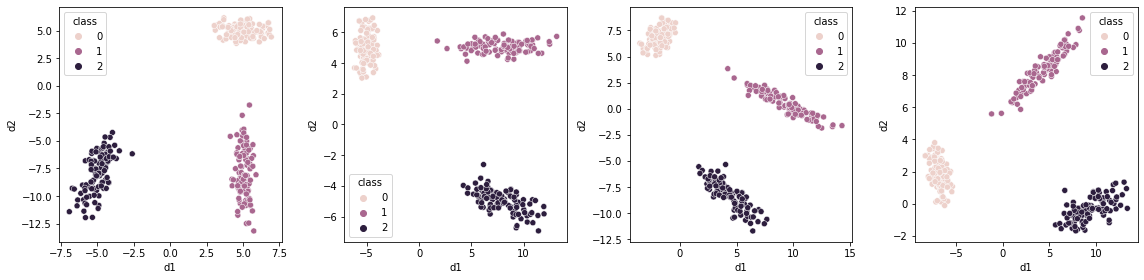

In [358]:
fig, ax = plt.subplots(1, 4, figsize=(16,4))
sns.scatterplot(data = A, x = 'd1', y='d2', hue='class', ax = ax[0])
sns.scatterplot(data = B, x = 'd1', y='d2', hue='class', ax = ax[1])
sns.scatterplot(data = C, x = 'd1', y='d2', hue='class', ax = ax[2])
sns.scatterplot(data = D, x = 'd1', y='d2', hue='class', ax = ax[3])
plt.tight_layout()

Create the target subject

In [7]:
theta = math.radians(270)
rot = np.array([[np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]])
T = (rot @ A[['d1', 'd2']].T).T
T.columns = ['d1', 'd2']
T['label'] = A['label']

#create the labeled and unlabeled subset
T_L = T.sample(frac=0.67)
T_U = T[~T.isin(T_L)].dropna()

# sns.scatterplot(data = T, x = 'd1', y='d2', hue='class')

In [21]:
# test on the estimator
A['source_no'] = [1] * len(A)
B['source_no'] = [2] * len(B)
C['source_no'] = [3] * len(C)
D['source_no'] = [4] * len(D)
T_L['source_no'] = [0] * len(T_L)

X_test, y_test = T_U[['d1', 'd2']], T_U['label']

train_df = pd.concat([T_L, A, B, C, D], ignore_index=True)
X_train, y_train = train_df[['d1', 'd2', 'source_no']], train_df['label']

from STM import STM

# , s36, s54
h = STM(
    n_domains=4, n_class=3, label = 'label', Cs=100, 
    kernels = 'poly', k_list = 1, beta_list = 0.1, gamma_list = 0.1, print_acc = False)
    # , SVM = True, best_sources=True)
h.fit(X_train, y_train)

h.score(X_test, y_test)

1.0

Train a classifier in each source domain and compute its classification accuracy on the labeled sample in the target domain.

Get 2 most accurate source subjects: A

Train SVM on each domain and remove the support vectors

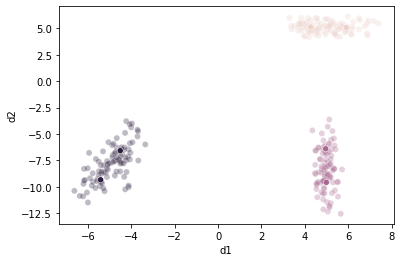

In [12]:
# checking KMeans results
# B_kmeans = B.copy()
# C_kmeans = C.copy()
# B_kmeans['labels'] = km_B.labels_
# C_kmeans['labels'] = km_C.labels_

# fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.scatterplot(data = A, x = 'd1', y='d2', hue='class', alpha = 0.3)
sns.scatterplot(data = proto_A, x = 'd1', y='d2', hue='class')
plt.legend([], [], frameon=False)
# sns.scatterplot(data = C, x = 'd1', y='d2', hue='class', ax = ax[1], alpha = 0.2)
# sns.scatterplot(data = proto_C, x = 'd1', y='d2', hue='class', ax = ax[1])

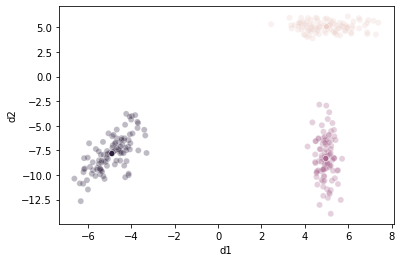

In [7]:
# case with k = 1
proto_A = find_prototypes(A, k=1, num_class = 3)
sns.scatterplot(data = A, x = 'd1', y='d2', hue='class', alpha = 0.3)
sns.scatterplot(data = proto_A, x = 'd1', y='d2', hue='class')
plt.legend([], [], frameon=False)

Map each target labeled sample feature vector to the nearest prototype in the same class

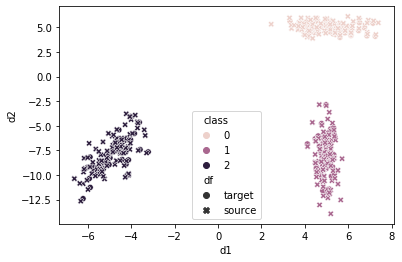

In [9]:
# ckpt 1: Find the destination point for each subject in the target data
# visualize to check the result
def visualize():
    A_temp = A.copy()
    A_temp['df'] = ['source'] * len(A_temp)
    X_A_df = pd.DataFrame(X_A, columns=['d1', 'd2'])
    X_A_df['class'] = A_preds
    X_A_df['df'] = ['target'] * len(X_A_df)
    X_A_df2 = X_A_df.append(A_temp)
    sns.scatterplot(data = X_A_df2, x = 'd1', y='d2', hue='class', style='df')
    plt.show()
visualize()

In [10]:
# # weighted average predictions across domains
# weighted_preds = np.round((A_score * A_preds)/(A_score))
# # accuracy score on test set
# np.mean(weighted_preds == T_U['class'])

1.0

In [ ]:
# # Save it & close the figure
# filename='/Users/irenechang/Downloads/ResearchFall2022/Viz/Viz-gamma'+str(gm)+'.png'
# plt.savefig(fname=filename, dpi=96)
# plt.gca()
# plt.close(fig)

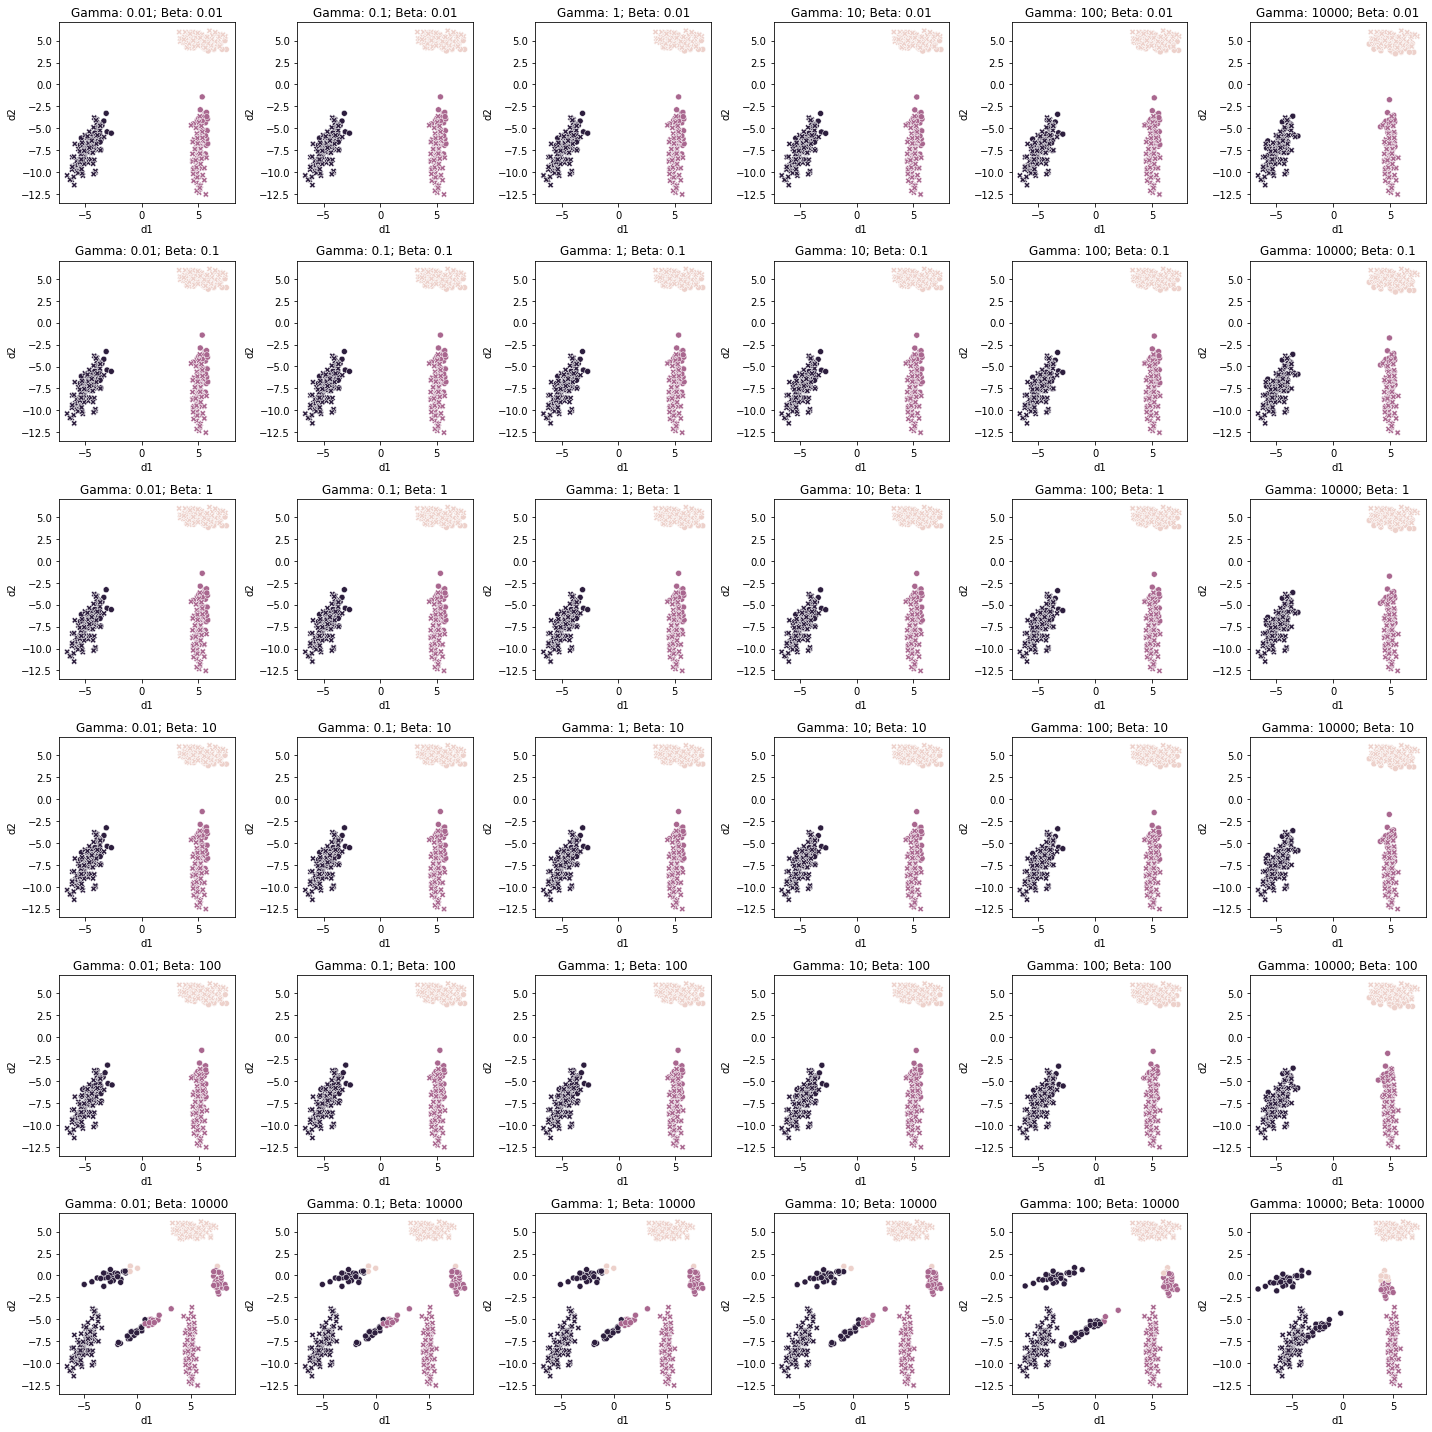

In [20]:
# log_space = [-2, -1, 0, 1, 2, 4]
# log_space = [10** i for i in log_space]

# proto_A = find_prototypes(A, k=3, num_class = 3)
# fig, axes = plt.subplots(6, 6, figsize=(20, 20))
# for i, beta in enumerate(log_space):
#     for j, gamma in enumerate(log_space):
#         preds, X = supervised_STM(target_df = T_L, source_df =proto_A, test_df = T_U, s_classifier = A_classifier, beta =beta, gamma = gamma)
#         temp = A.copy()
#         temp['df'] = ['source'] * len(temp)
#         X_df = pd.DataFrame(X, columns=['d1', 'd2'])
#         X_df['class'] = preds
#         X_df['df'] = ['target'] * len(X_df)
#         X_df2 = X_df.append(temp)
#         sns.scatterplot(data = X_df2, x = 'd1', y='d2', hue='class', style='df', ax=axes[i][j])
#         ax=axes[i][j].set_title('Gamma: ' + str(gamma) + "; Beta: "+str(beta) )
#         # ax=axes[i][j].set_ylim(-15, 15)
#         ax=axes[i][j].legend([], [], frameon=False)
#         plt.tight_layout()

## Try on the real dataset

#### Method of selecting data
I want to extract 50 instances in each of the 4 classes for each subject by random sampling. In other words, there are 200 windows that will be randomly selected from the 1488 windows. 

In [124]:
train_dfs, t23_test = make_datasets(sources = [7, 75], target=23)

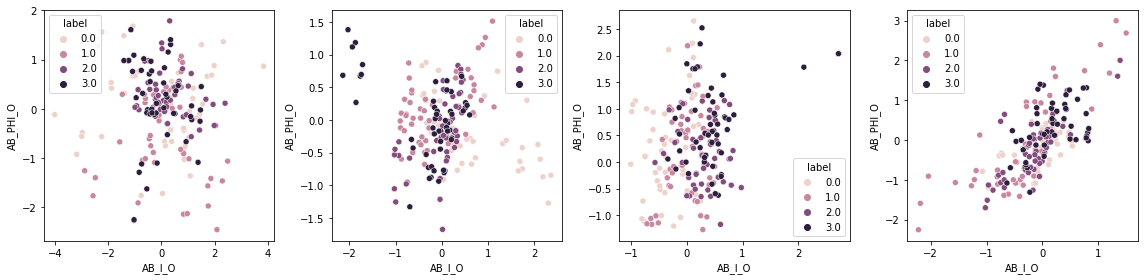

In [30]:
fig, ax = plt.subplots(1, 4, figsize=(16,4))
sns.scatterplot(data = s7, x = 'AB_I_O', y='AB_PHI_O', hue='label', ax = ax[0])
sns.scatterplot(data = s75, x = 'AB_I_O', y='AB_PHI_O', hue='label', ax = ax[1])
sns.scatterplot(data = s44, x = 'AB_I_O', y='AB_PHI_O', hue='label', ax = ax[2])
sns.scatterplot(data = s91, x = 'AB_I_O', y='AB_PHI_O', hue='label', ax = ax[3])
plt.tight_layout()

In [11]:
# # baseline weighted average predictions across domains
# weighted_preds = np.round((
#     s7_score * s7_classifier.predict(t23_test[feature_list]) + 
#     s75_score * s75_classifier.predict(t23_test[feature_list]) + 
#     s91_score * s91_classifier.predict(t23_test[feature_list]) +
#     s44_score * s44_classifier.predict(t23_test[feature_list]))/(
#         s7_score + 
#         s75_score + 
#         s91_score + 
#         s44_score))
# # accuracy score on test set
# np.mean(weighted_preds == t23_test['label'])

0.36363636363636365

In [60]:
# # another baseline, LR trained on t23_train and tested on t23_test
# feature_list = list(s7.columns)[:-1]
# _, base_score = build_source_classifier(t23_train, features=feature_list, y='label',target_df= t23_train)
# print(base_score)

0.582089552238806


1. Select data, assign trainn and test and validation
2. Grid search
3. Performance without SVM

## More domains included

In [269]:
# third metric and val + test acc computed at the same time
# stm_acc_val_63 = []
# stm_acc_test_63 = []
# third_base_63 = []
# model_63 = []
sources = [7, 34, 36, 44, 49, 52, 54, 75, 83, 91]
for i in [10]:
    beta_tune = list(itertools.product(*([[0.001, 0.01, 0.1, 1]] * i)))
    gamma_tune = list(itertools.product(*([[0.001, 0.01, 0.1, 1]] * i)))
    k_tune = list(itertools.product(*([[1, 2]] * i)))
    tuned_params = {"beta_list": beta_tune, "gamma_list": gamma_tune, "k_list": k_tune}
    (Xtrain_dfs, ytrain_dfs), (Xt23_test, yt23_test) = make_datasets(sources = sources[:i], target=63, n = 1)
    custom_cv = [train_test_split(Xtrain_dfs)]
    rs = RandomizedSearchCV(STM(n_domains = i), param_distributions = tuned_params, cv = custom_cv, n_iter=50)
    rs.fit(Xtrain_dfs, ytrain_dfs)
    # val acc
    stm_acc_val_63.append(rs.best_score_)
    # test acc
    stm_acc_test_63.append(rs.score(Xt23_test, yt23_test))
    # weighted avergae
    third_base_63.append(rs.best_estimator_.third_metric(Xt23_test, yt23_test))
    model_63.append(rs.best_estimator_)

In [326]:
# second metric
# bl1_acc_23 = []
# for i in [1, 5, 7, 10]:
#     (Xtrain_dfs, ytrain_dfs), (Xt23_test, yt23_test) = make_datasets(sources = sources[:i], target=23, n = 1)
#     train_X = Xtrain_dfs[Xtrain_dfs.source_no != 0]
#     train_y = ytrain_dfs[train_X.index]
#     lr = RandomForestClassifier().fit(train_X.drop('source_no', axis=1), train_y)
#     bl1_acc_23.append(lr.score(Xt23_test, yt23_test))

# bl1_acc_58 =[]
# for i in [10]:
#     (Xtrain_dfs, ytrain_dfs), (Xt23_test, yt23_test) = make_datasets(sources = sources[:i], target=58, n = 1)
#     train_X = Xtrain_dfs[Xtrain_dfs.source_no != 0]
#     train_y = ytrain_dfs[train_X.index]
#     lr = RandomForestClassifier().fit(train_X.drop('source_no', axis=1), train_y)
#     bl1_acc_58.append(lr.score(Xt23_test, yt23_test))

# bl1_acc_63 =[]
# for i in [10]:
#     (Xtrain_dfs, ytrain_dfs), (Xt23_test, yt23_test) = make_datasets(sources = sources[:i], target=63, n = 1)
#     train_X = Xtrain_dfs[Xtrain_dfs.source_no != 0]
#     train_y = ytrain_dfs[train_X.index]
#     lr = RandomForestClassifier().fit(train_X.drop('source_no', axis=1), train_y)
#     bl1_acc_63.append(lr.score(Xt23_test, yt23_test))

# bl1_acc_95 =[]
# for i in [10]:
#     (Xtrain_dfs, ytrain_dfs), (Xt23_test, yt23_test) = make_datasets(sources = sources[:i], target=95, n = 1)
#     train_X = Xtrain_dfs[Xtrain_dfs.source_no != 0]
#     train_y = ytrain_dfs[train_X.index]
#     lr = RandomForestClassifier().fit(train_X.drop('source_no', axis=1), train_y)
#     bl1_acc_95.append(lr.score(Xt23_test, yt23_test))

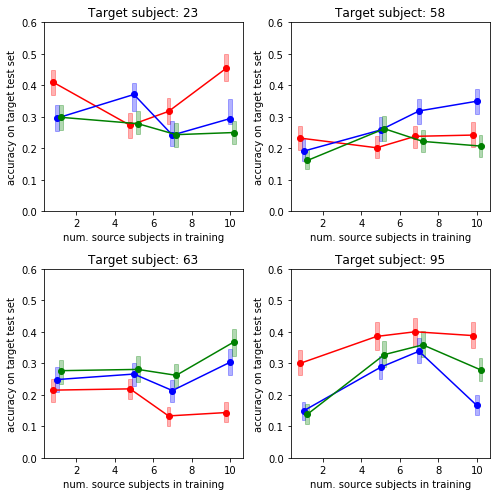

In [363]:
palette = {'STM': 'red', 'weighted avg': 'green', 'generic': 'blue'}
fig = plt.figure(figsize=(7, 7))
f1 = fig.add_subplot(221)
plt.plot([1-0.2, 5-0.2, 7-0.2, 10-0.2], stm_acc_test_23, label='STM', c = palette['STM'], marker='o')
plt.plot([1, 5, 7, 10], bl1_acc_23, label='generic', c = palette['generic'], marker='o')
plt.plot([1.2, 5.2, 7.2, 10.2], third_base_23, label='weighted avg', c = palette['weighted avg'], marker='o')

plt.ylim(0, 0.6)
f1.add_patch(
    patches.Rectangle((1 - 0.3, np.percentile(score_list_23_1, [2.5])), 
    height = np.percentile(score_list_23_1, [97.5]) - np.percentile(score_list_23_1, [2.5]), width = 0.2, color='red', alpha=0.3))
f1.add_patch(
    patches.Rectangle((1 - 0.1, np.percentile(score_list_base_23_1, [2.5])), 
    height = np.percentile(score_list_base_23_1, [97.5]) - np.percentile(score_list_base_23_1, [2.5]), width = 0.2, color='blue', alpha=0.3))
f1.add_patch(
    patches.Rectangle((5 - 0.3, np.percentile(score_list_23_5, [2.5])), 
    height = np.percentile(score_list_23_5, [97.5]) - np.percentile(score_list_23_5, [2.5]), width = 0.2, color='red', alpha=0.3))
f1.add_patch(
    patches.Rectangle((5 - 0.1, np.percentile(score_list_base_23_5, [2.5])), 
    height = np.percentile(score_list_base_23_5, [97.5]) - np.percentile(score_list_base_23_5, [2.5]), width = 0.2, color='blue', alpha=0.3))
f1.add_patch(
    patches.Rectangle((7 - 0.3, np.percentile(score_list_23_7, [2.5])), 
    height = np.percentile(score_list_23_7, [97.5]) - np.percentile(score_list_23_7, [2.5]), width = 0.2, color='red', alpha=0.3))
f1.add_patch(
    patches.Rectangle((7 - 0.1, np.percentile(score_list_base_23_7, [2.5])), 
    height = np.percentile(score_list_base_23_7, [97.5]) - np.percentile(score_list_base_23_7, [2.5]), width = 0.2, color='blue', alpha=0.3))
f1.add_patch(
    patches.Rectangle((10 - 0.3, np.percentile(score_list_23_10, [2.5])), 
    height = np.percentile(score_list_23_10, [97.5]) - np.percentile(score_list_23_10, [2.5]), width = 0.2, color='red', alpha=0.3))
f1.add_patch(
    patches.Rectangle((10 - 0.1, np.percentile(score_list_base_23_10, [2.5])), 
    height = np.percentile(score_list_base_23_10, [97.5]) - np.percentile(score_list_base_23_10, [2.5]), width = 0.2, color='blue', alpha=0.3))
f1.add_patch(
    patches.Rectangle((1.1, np.percentile(score_list_third_23_1, [2.5])), 
    height = np.percentile(score_list_third_23_1, [97.5]) - np.percentile(score_list_third_23_1, [2.5]), width = 0.2, color='green', alpha=0.3))
f1.add_patch(
    patches.Rectangle((5.1, np.percentile(score_list_third_23_5, [2.5])), 
    height = np.percentile(score_list_third_23_5, [97.5]) - np.percentile(score_list_third_23_5, [2.5]), width = 0.2, color='green', alpha=0.3))
f1.add_patch(
    patches.Rectangle((7.1, np.percentile(score_list_third_23_7, [2.5])), 
    height = np.percentile(score_list_third_23_7, [97.5]) - np.percentile(score_list_third_23_7, [2.5]), width = 0.2, color='green', alpha=0.3))
f1.add_patch(
    patches.Rectangle((10.1, np.percentile(score_list_third_23_10, [2.5])), 
    height = np.percentile(score_list_third_23_10, [97.5]) - np.percentile(score_list_third_23_10, [2.5]), width = 0.2, color='green', alpha=0.3))
plt.xlabel("num. source subjects in training")
plt.ylabel("accuracy on target test set")
plt.title("Target subject: 23")

f2 = fig.add_subplot(222)
plt.plot([1-0.2, 5-0.2, 7-0.2, 10-0.2], stm_acc_test_58, label='STM', c = palette['STM'], marker='o')
plt.plot([1, 5, 7, 10], bl1_acc_58, label='generic', c = palette['generic'], marker='o')
plt.plot([1.2, 5.2, 7.2, 10.2], third_base_58, label='weighted avg', c = palette['weighted avg'], marker='o')
plt.xlabel("num. source subjects in training")
plt.ylabel("accuracy on target test set")
plt.title("Target subject: 58")
plt.ylim(0, 0.6)
f2.add_patch(
    patches.Rectangle((1 - 0.3, np.percentile(score_list_58_1, [2.5])), 
    height = np.percentile(score_list_58_1, [97.5]) - np.percentile(score_list_58_1, [2.5]), width = 0.2, color='red', alpha=0.3))
f2.add_patch(
    patches.Rectangle((1 - 0.1, np.percentile(score_list_base_58_1, [2.5])), 
    height = np.percentile(score_list_base_58_1, [97.5]) - np.percentile(score_list_base_58_1, [2.5]), width = 0.2, color='blue', alpha=0.3))
f2.add_patch(
    patches.Rectangle((5 - 0.3, np.percentile(score_list_58_5, [2.5])), 
    height = np.percentile(score_list_58_5, [97.5]) - np.percentile(score_list_58_5, [2.5]), width = 0.2, color='red', alpha=0.3))
f2.add_patch(
    patches.Rectangle((5 - 0.1, np.percentile(score_list_base_58_5, [2.5])), 
    height = np.percentile(score_list_base_58_5, [97.5]) - np.percentile(score_list_base_58_5, [2.5]), width = 0.2, color='blue', alpha=0.3))
f2.add_patch(
    patches.Rectangle((7 - 0.3, np.percentile(score_list_58_7, [2.5])), 
    height = np.percentile(score_list_58_7, [97.5]) - np.percentile(score_list_58_7, [2.5]), width = 0.2, color='red', alpha=0.3))
f2.add_patch(
    patches.Rectangle((7 - 0.1, np.percentile(score_list_base_58_7, [2.5])), 
    height = np.percentile(score_list_base_58_7, [97.5]) - np.percentile(score_list_base_58_7, [2.5]), width = 0.2, color='blue', alpha=0.3))
f2.add_patch(
    patches.Rectangle((10 - 0.3, np.percentile(score_list_58_10, [2.5])), 
    height = np.percentile(score_list_58_10, [97.5]) - np.percentile(score_list_58_10, [2.5]), width = 0.2, color='red', alpha=0.3))
f2.add_patch(
    patches.Rectangle((10 - 0.1, np.percentile(score_list_base_58_10, [2.5])), 
    height = np.percentile(score_list_base_58_10, [97.5]) - np.percentile(score_list_base_58_10, [2.5]), width = 0.2, color='blue', alpha=0.3))
f2.add_patch(
    patches.Rectangle((1.1, np.percentile(score_list_third_58_1, [2.5])), 
    height = np.percentile(score_list_third_58_1, [97.5]) - np.percentile(score_list_third_58_1, [2.5]), width = 0.2, color='green', alpha=0.3))
f2.add_patch(
    patches.Rectangle((5.1, np.percentile(score_list_third_58_5, [2.5])), 
    height = np.percentile(score_list_third_58_5, [97.5]) - np.percentile(score_list_third_58_5, [2.5]), width = 0.2, color='green', alpha=0.3))
f2.add_patch(
    patches.Rectangle((7.1, np.percentile(score_list_third_58_7, [2.5])), 
    height = np.percentile(score_list_third_58_7, [97.5]) - np.percentile(score_list_third_58_7, [2.5]), width = 0.2, color='green', alpha=0.3))
f2.add_patch(
    patches.Rectangle((10.1, np.percentile(score_list_third_58_10, [2.5])), 
    height = np.percentile(score_list_third_58_10, [97.5]) - np.percentile(score_list_third_58_10, [2.5]), width = 0.2, color='green', alpha=0.3))

f3 = fig.add_subplot(223)
plt.plot([1-0.2, 5-0.2, 7-0.2, 10-0.2], stm_acc_test_63, label='STM', c = palette['STM'], marker='o')
plt.plot([1, 5, 7, 10], bl1_acc_63, label='generic', c = palette['generic'], marker='o')
plt.plot([1.2, 5.2, 7.2, 10.2], third_base_63, label='weighted avg', c = palette['weighted avg'], marker='o')
plt.xlabel("num. source subjects in training")
plt.ylabel("accuracy on target test set")
plt.title("Target subject: 63")
plt.ylim(0, 0.6)
f3.add_patch(
    patches.Rectangle((1 - 0.3, np.percentile(score_list_63_1, [2.5])), 
    height = np.percentile(score_list_63_1, [97.5]) - np.percentile(score_list_63_1, [2.5]), width = 0.2, color='red', alpha=0.3))
f3.add_patch(
    patches.Rectangle((1 - 0.1, np.percentile(score_list_base_63_1, [2.5])), 
    height = np.percentile(score_list_base_63_1, [97.5]) - np.percentile(score_list_base_63_1, [2.5]), width = 0.2, color='blue', alpha=0.3))
f3.add_patch(
    patches.Rectangle((5 - 0.3, np.percentile(score_list_63_5, [2.5])), 
    height = np.percentile(score_list_63_5, [97.5]) - np.percentile(score_list_63_5, [2.5]), width = 0.2, color='red', alpha=0.3))
f3.add_patch(
    patches.Rectangle((5 - 0.1, np.percentile(score_list_base_63_5, [2.5])), 
    height = np.percentile(score_list_base_63_5, [97.5]) - np.percentile(score_list_base_63_5, [2.5]), width = 0.2, color='blue', alpha=0.3))
f3.add_patch(
    patches.Rectangle((7 - 0.3, np.percentile(score_list_63_7, [2.5])), 
    height = np.percentile(score_list_63_7, [97.5]) - np.percentile(score_list_63_7, [2.5]), width = 0.2, color='red', alpha=0.3))
f3.add_patch(
    patches.Rectangle((7 - 0.1, np.percentile(score_list_base_63_7, [2.5])), 
    height = np.percentile(score_list_base_63_7, [97.5]) - np.percentile(score_list_base_63_7, [2.5]), width = 0.2, color='blue', alpha=0.3))
f3.add_patch(
    patches.Rectangle((10 - 0.3, np.percentile(score_list_63_10, [2.5])), 
    height = np.percentile(score_list_63_10, [97.5]) - np.percentile(score_list_63_10, [2.5]), width = 0.2, color='red', alpha=0.3))
f3.add_patch(
    patches.Rectangle((10 - 0.1, np.percentile(score_list_base_63_10, [2.5])), 
    height = np.percentile(score_list_base_63_10, [97.5]) - np.percentile(score_list_base_63_10, [2.5]), width = 0.2, color='blue', alpha=0.3))
f3.add_patch(
    patches.Rectangle((1.1, np.percentile(score_list_third_63_1, [2.5])), 
    height = np.percentile(score_list_third_63_1, [97.5]) - np.percentile(score_list_third_63_1, [2.5]), width = 0.2, color='green', alpha=0.3))
f3.add_patch(
    patches.Rectangle((5.1, np.percentile(score_list_third_63_5, [2.5])), 
    height = np.percentile(score_list_third_63_5, [97.5]) - np.percentile(score_list_third_63_5, [2.5]), width = 0.2, color='green', alpha=0.3))
f3.add_patch(
    patches.Rectangle((7.1, np.percentile(score_list_third_63_7, [2.5])), 
    height = np.percentile(score_list_third_63_7, [97.5]) - np.percentile(score_list_third_63_7, [2.5]), width = 0.2, color='green', alpha=0.3))
f3.add_patch(
    patches.Rectangle((10.1, np.percentile(score_list_third_63_10, [2.5])), 
    height = np.percentile(score_list_third_63_10, [97.5]) - np.percentile(score_list_third_63_10, [2.5]), width = 0.2, color='green', alpha=0.3))

f4 = fig.add_subplot(224)
plt.plot([1-0.2, 5-0.2, 7-0.2, 10-0.2], stm_acc_test_95, label='STM', c = palette['STM'], marker='o')
plt.plot([1, 5, 7, 10], bl1_acc_95, label='generic', c = palette['generic'], marker='o')
plt.plot([1.2, 5.2, 7.2, 10.2], third_base_95, label='weighted avg', c = palette['weighted avg'], marker='o')
plt.xlabel("num. source subjects in training")
plt.ylabel("accuracy on target test set")
plt.title("Target subject: 95")
plt.ylim(0, 0.6)
f4.add_patch(
    patches.Rectangle((1 - 0.3, np.percentile(score_list_95_1, [2.5])), 
    height = np.percentile(score_list_95_1, [97.5]) - np.percentile(score_list_95_1, [2.5]), width = 0.2, color='red', alpha=0.3))
f4.add_patch(
    patches.Rectangle((1 - 0.1, np.percentile(score_list_base_95_1, [2.5])), 
    height = np.percentile(score_list_base_95_1, [97.5]) - np.percentile(score_list_base_95_1, [2.5]), width = 0.2, color='blue', alpha=0.3))
f4.add_patch(
    patches.Rectangle((5 - 0.3, np.percentile(score_list_95_5, [2.5])), 
    height = np.percentile(score_list_95_5, [97.5]) - np.percentile(score_list_95_5, [2.5]), width = 0.2, color='red', alpha=0.3))
f4.add_patch(
    patches.Rectangle((5 - 0.1, np.percentile(score_list_base_95_5, [2.5])), 
    height = np.percentile(score_list_base_95_5, [97.5]) - np.percentile(score_list_base_95_5, [2.5]), width = 0.2, color='blue', alpha=0.3))
f4.add_patch(
    patches.Rectangle((7 - 0.3, np.percentile(score_list_95_7, [2.5])), 
    height = np.percentile(score_list_95_7, [97.5]) - np.percentile(score_list_95_7, [2.5]), width = 0.2, color='red', alpha=0.3))
f4.add_patch(
    patches.Rectangle((7 - 0.1, np.percentile(score_list_base_95_7, [2.5])), 
    height = np.percentile(score_list_base_95_7, [97.5]) - np.percentile(score_list_base_95_7, [2.5]), width = 0.2, color='blue', alpha=0.3))
f4.add_patch(
    patches.Rectangle((10 - 0.3, np.percentile(score_list_95_10, [2.5])), 
    height = np.percentile(score_list_95_10, [97.5]) - np.percentile(score_list_95_10, [2.5]), width = 0.2, color='red', alpha=0.3))
f4.add_patch(
    patches.Rectangle((10 - 0.1, np.percentile(score_list_base_95_10, [2.5])), 
    height = np.percentile(score_list_base_95_10, [97.5]) - np.percentile(score_list_base_95_10, [2.5]), width = 0.2, color='blue', alpha=0.3))
f4.add_patch(
    patches.Rectangle((1.1, np.percentile(score_list_third_95_1, [2.5])), 
    height = np.percentile(score_list_third_95_1, [97.5]) - np.percentile(score_list_third_95_1, [2.5]), width = 0.2, color='green', alpha=0.3))
f4.add_patch(
    patches.Rectangle((5.1, np.percentile(score_list_third_95_5, [2.5])), 
    height = np.percentile(score_list_third_95_5, [97.5]) - np.percentile(score_list_third_95_5, [2.5]), width = 0.2, color='green', alpha=0.3))
f4.add_patch(
    patches.Rectangle((7.1, np.percentile(score_list_third_95_7, [2.5])), 
    height = np.percentile(score_list_third_95_7, [97.5]) - np.percentile(score_list_third_95_7, [2.5]), width = 0.2, color='green', alpha=0.3))
f4.add_patch(
    patches.Rectangle((10.1, np.percentile(score_list_third_95_10, [2.5])), 
    height = np.percentile(score_list_third_95_10, [97.5]) - np.percentile(score_list_third_95_10, [2.5]), width = 0.2, color='green', alpha=0.3))
plt.tight_layout()

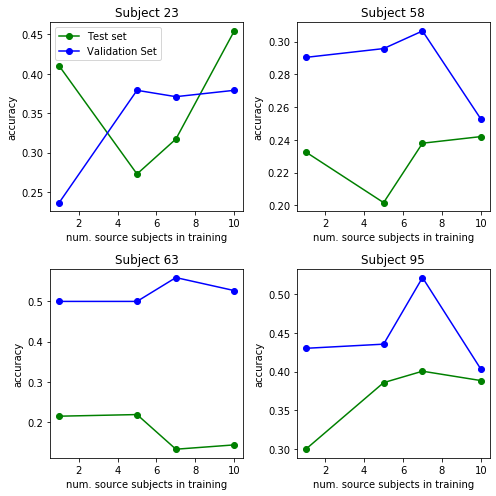

In [282]:
palette2 = {'Test set': 'green', 'Validation Set': 'blue'}
fig = plt.figure(figsize=(7, 7))
fig.add_subplot(221)
plt.plot([1, 5, 7, 10], stm_acc_test_23, label='Test set', c = palette2['Test set'], marker='o')
plt.plot([1, 5, 7, 10], stm_acc_val_23, label='Validation Set', c = palette2['Validation Set'], marker='o')
plt.xlabel("num. source subjects in training")
plt.ylabel("accuracy")
plt.title("Subject 23")
plt.legend()

fig.add_subplot(222)
plt.plot([1, 5, 7, 10], stm_acc_test_58, label='Test set', c = palette2['Test set'], marker='o')
plt.plot([1, 5, 7, 10], stm_acc_val_58, label='Validation Set', c = palette2['Validation Set'], marker='o')
plt.xlabel("num. source subjects in training")
plt.ylabel("accuracy")
plt.title("Subject 58")

fig.add_subplot(223)
plt.plot([1, 5, 7, 10], stm_acc_test_63, label='Test set', c = palette2['Test set'], marker='o')
plt.plot([1, 5, 7, 10], stm_acc_val_63, label='Validation Set', c = palette2['Validation Set'], marker='o')
plt.xlabel("num. source subjects in training")
plt.ylabel("accuracy")
plt.title("Subject 63")

fig.add_subplot(224)
plt.plot([1, 5, 7, 10], stm_acc_test_95, label='Test set', c = palette2['Test set'], marker='o')
plt.plot([1, 5, 7, 10], stm_acc_val_95, label='Validation Set', c = palette2['Validation Set'], marker='o')
plt.xlabel("num. source subjects in training")
plt.ylabel("accuracy")
plt.title("Subject 95")

plt.tight_layout()

In [362]:
#sampling with replacement
# (Xtrain_dfs, ytrain_dfs), (Xt23_test, yt23_test) = make_datasets(sources = sources[:1], target=95, n = 1)
# score_list_third_95_1 = []
# score_list_third_95_5 = []
# score_list_third_95_7 = []
# score_list_third_95_10 = []

for i in range(1000):
    sample_X = Xt23_test.sample(n=500, replace=True)
    sample_y = yt23_test[sample_X.index]

    # score_list_third_95_1.append(model_95[0].third_metric(sample_X, sample_y))
    # score_list_third_95_5.append(model_95[1].third_metric(sample_X, sample_y))
    # score_list_third_95_7.append(model_95[2].third_metric(sample_X, sample_y))
    # score_list_third_95_10.append(model_95[3].third_metric(sample_X, sample_y))


In [60]:
t_df_train.head()

,AB_I_O,AB_PHI_O,AB_I_DO,AB_PHI_DO,CD_I_O,CD_PHI_O,CD_I_DO,CD_PHI_DO,label
0,-1.522985,-0.909367,-0.270934,0.319133,-0.849062,-0.009065,-0.146850,0.923350,0.0
1,-1.466459,-0.902933,-0.258630,0.314695,-0.827839,-0.026762,-0.152973,0.914992,0.0
2,-1.412589,-0.902636,-0.245801,0.311096,-0.807509,-0.049054,-0.158924,0.909724,0.0
3,-1.362895,-0.909095,-0.232813,0.308415,-0.788604,-0.071295,-0.164316,0.907316,0.0
4,-1.317715,-0.921051,-0.219997,0.306221,-0.771797,-0.089179,-0.168912,0.906776,0.0


In [107]:
t_df, _ = make_target(95)
num_target_train = int(len(t_df)/2)
t_df_train, t_df_test = t_df.iloc[:num_target_train, :], t_df.iloc[num_target_train:, :]

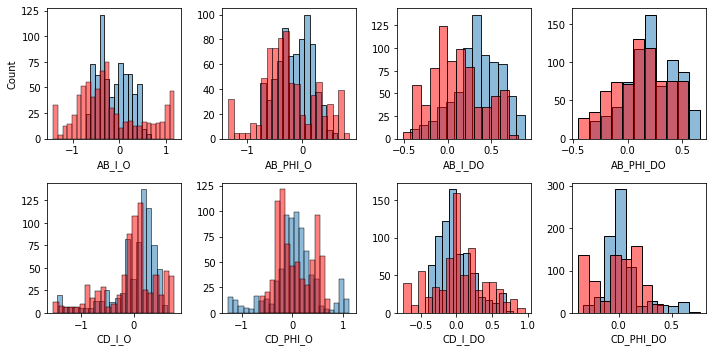

In [110]:
fig = plt.figure(figsize=(10, 5))
f1 = fig.add_subplot(241)
sns.histplot(x = t_df_train['AB_I_O'], alpha=0.5, binwidth=0.1)
sns.histplot(x = t_df_test['AB_I_O'], color='red', alpha=0.5, binwidth=0.1)
f1 = fig.add_subplot(242)
sns.histplot(x = t_df_train['AB_PHI_O'], alpha=0.5, binwidth=0.1)
sns.histplot(x = t_df_test['AB_PHI_O'], color='red', alpha=0.5, binwidth=0.1)
plt.ylabel("")
f1 = fig.add_subplot(243)
sns.histplot(x = t_df_train['AB_I_DO'], alpha=0.5, binwidth=0.1)
sns.histplot(x = t_df_test['AB_I_DO'], color='red', alpha=0.5, binwidth=0.1)
plt.ylabel("")
f1 = fig.add_subplot(244)
sns.histplot(x = t_df_train['AB_PHI_DO'], alpha=0.5, binwidth=0.1)
sns.histplot(x = t_df_test['AB_PHI_DO'], color='red', alpha=0.5, binwidth=0.1)
plt.ylabel("")
f1 = fig.add_subplot(245)
sns.histplot(x = t_df_train['CD_I_O'], alpha=0.5, binwidth=0.1)
sns.histplot(x = t_df_test['CD_I_O'], color='red', alpha=0.5, binwidth=0.1)
plt.ylabel("")
f1 = fig.add_subplot(246)
sns.histplot(x = t_df_train['CD_PHI_O'], alpha=0.5, binwidth=0.1)
sns.histplot(x = t_df_test['CD_PHI_O'], color='red', alpha=0.5, binwidth=0.1)
plt.ylabel("")
f1 = fig.add_subplot(247)
sns.histplot(x = t_df_train['CD_I_DO'], alpha=0.5, binwidth=0.1)
sns.histplot(x = t_df_test['CD_I_DO'], color='red', alpha=0.5, binwidth=0.1)
plt.ylabel("")
f1 = fig.add_subplot(248)
sns.histplot(x = t_df_train['CD_PHI_DO'], alpha=0.5, binwidth=0.1)
sns.histplot(x = t_df_test['CD_PHI_DO'], color='red', alpha=0.5, binwidth=0.1)
plt.ylabel("")
plt.tight_layout()

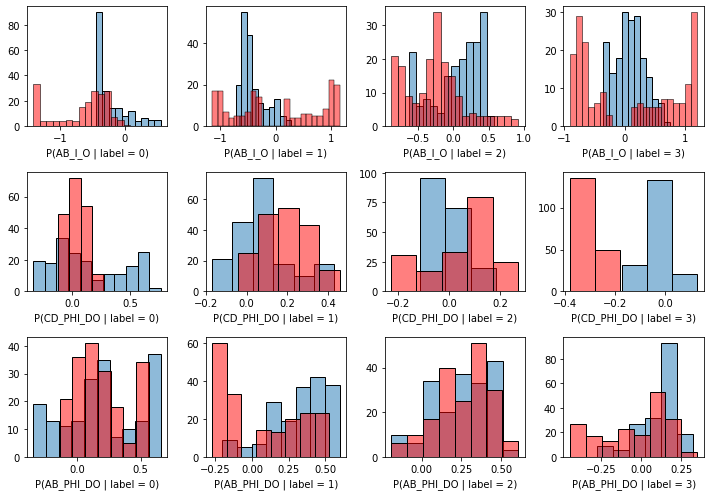

In [109]:
fig = plt.figure(figsize=(10, 7))
f1 = fig.add_subplot(341)
sns.histplot(data = t_df_train[t_df_train.label==0], x = 'AB_I_O', alpha=0.5, binwidth=0.1)
sns.histplot(data = t_df_test[t_df_test.label==0], x = 'AB_I_O', alpha=0.5, binwidth=0.1, color='red')
plt.ylabel("")
plt.xlabel("P(AB_I_O | label = 0)")

f1 = fig.add_subplot(342)
sns.histplot(data = t_df_train[t_df_train.label==1], x = 'AB_I_O', alpha=0.5, binwidth=0.1)
sns.histplot(data = t_df_test[t_df_test.label==1], x = 'AB_I_O', alpha=0.5, binwidth=0.1, color='red')
plt.ylabel("")
plt.xlabel("P(AB_I_O | label = 1)")

f1 = fig.add_subplot(343)
sns.histplot(data = t_df_train[t_df_train.label==2], x = 'AB_I_O', alpha=0.5, binwidth=0.1)
sns.histplot(data = t_df_test[t_df_test.label==2], x = 'AB_I_O', alpha=0.5, binwidth=0.1, color='red')
plt.ylabel("")
plt.xlabel("P(AB_I_O | label = 2)")

f1 = fig.add_subplot(344)
sns.histplot(data = t_df_train[t_df_train.label==3], x = 'AB_I_O', alpha=0.5, binwidth=0.1)
sns.histplot(data = t_df_test[t_df_test.label==3], x = 'AB_I_O', alpha=0.5, binwidth=0.1, color='red')
plt.ylabel("")
plt.xlabel("P(AB_I_O | label = 3)")

f1 = fig.add_subplot(345)
sns.histplot(data = t_df_train[t_df_train.label==0], x = 'CD_PHI_DO', alpha=0.5, binwidth=0.1)
sns.histplot(data = t_df_test[t_df_test.label==0], x = 'CD_PHI_DO', alpha=0.5, binwidth=0.1, color='red')
plt.ylabel("")
plt.xlabel("P(CD_PHI_DO | label = 0)")

f1 = fig.add_subplot(346)
sns.histplot(data = t_df_train[t_df_train.label==1], x = 'CD_PHI_DO', alpha=0.5, binwidth=0.1)
sns.histplot(data = t_df_test[t_df_test.label==1], x = 'CD_PHI_DO', alpha=0.5, binwidth=0.1, color='red')
plt.ylabel("")
plt.xlabel("P(CD_PHI_DO | label = 1)")

f1 = fig.add_subplot(347)
sns.histplot(data = t_df_train[t_df_train.label==2], x = 'CD_PHI_DO', alpha=0.5, binwidth=0.1)
sns.histplot(data = t_df_test[t_df_test.label==2], x = 'CD_PHI_DO', alpha=0.5, binwidth=0.1, color='red')
plt.ylabel("")
plt.xlabel("P(CD_PHI_DO | label = 2)")

f1 = fig.add_subplot(348)
sns.histplot(data = t_df_train[t_df_train.label==3], x = 'CD_PHI_DO', alpha=0.5, binwidth=0.1)
sns.histplot(data = t_df_test[t_df_test.label==3], x = 'CD_PHI_DO', alpha=0.5, binwidth=0.1, color='red')
plt.ylabel("")
plt.xlabel("P(CD_PHI_DO | label = 3)")

f1 = fig.add_subplot(349)
sns.histplot(data = t_df_train[t_df_train.label==0], x = 'AB_PHI_DO', alpha=0.5, binwidth=0.1)
sns.histplot(data = t_df_test[t_df_test.label==0], x = 'AB_PHI_DO', alpha=0.5, binwidth=0.1, color='red')
plt.ylabel("")
plt.xlabel("P(AB_PHI_DO | label = 0)")

f1 = fig.add_subplot(3,4,10)
sns.histplot(data = t_df_train[t_df_train.label==1], x = 'AB_PHI_DO', alpha=0.5, binwidth=0.1)
sns.histplot(data = t_df_test[t_df_test.label==1], x = 'AB_PHI_DO', alpha=0.5, binwidth=0.1, color='red')
plt.ylabel("")
plt.xlabel("P(AB_PHI_DO | label = 1)")

f1 = fig.add_subplot(3,4,11)
sns.histplot(data = t_df_train[t_df_train.label==2], x = 'AB_PHI_DO', alpha=0.5, binwidth=0.1)
sns.histplot(data = t_df_test[t_df_test.label==2], x = 'AB_PHI_DO', alpha=0.5, binwidth=0.1, color='red')
plt.ylabel("")
plt.xlabel("P(AB_PHI_DO | label = 2)")

f1 = fig.add_subplot(3,4,12)
sns.histplot(data = t_df_train[t_df_train.label==3], x = 'AB_PHI_DO', alpha=0.5, binwidth=0.1)
sns.histplot(data = t_df_test[t_df_test.label==3], x = 'AB_PHI_DO', alpha=0.5, binwidth=0.1, color='red')
plt.ylabel("")
plt.xlabel("P(AB_PHI_DO | label = 3)")
plt.tight_layout()

In [45]:
h1_test_score = []
h2_test_score = []
h3_test_score = []
h4_test_score = []
for i in range(1000):
    sample_X = Xt23_test.sample(n=500, replace=True)
    sample_y = yt23_test[sample_X.index]
    h1_test_score.append(h1.score(sample_X, sample_y))
    h2_test_score.append(h2.score(sample_X, sample_y))
    h3_test_score.append(h3.score(sample_X, sample_y))
    h4_test_score.append(h4.score(sample_X, sample_y))

In [ ]:
# total = pd.DataFrame(diff_test, columns = ['acc'])
# total['subj'] = 63
# total['n_dom'] = 'STM'
# total

In [55]:
temp = pd.DataFrame(diff_test, columns = ['acc'])
temp['subj'] = 58
temp['n_dom'] = 'SVM'
total = pd.concat([total, temp], ignore_index=True)

temp = pd.DataFrame(diff_test2, columns = ['acc'])
temp['subj'] = 58
temp['n_dom'] = 'BSS'
total = pd.concat([total, temp], ignore_index=True)

temp = pd.DataFrame(diff_test3, columns = ['acc'])
temp['subj'] = 58
temp['n_dom'] = 'BSS + SVM'
total = pd.concat([total, temp], ignore_index=True)

In [56]:
total

,acc,subj,n_dom
0,-0.036,63,SVM
1,-0.020,63,SVM
2,-0.002,63,SVM
3,-0.074,63,SVM
4,-0.024,63,SVM
...,...,...,...
8995,-0.156,58,BSS + SVM
8996,-0.132,58,BSS + SVM
8997,-0.186,58,BSS + SVM
8998,-0.152,58,BSS + SVM


In [33]:
# n_domains = 10
# sources = [7, 34, 36, 44, 49, 52, 54, 75, 83, 91]
# beta_tune = list(itertools.product(*([[0.01, 0.1, 1]] * n_domains)))
# gamma_tune = list(itertools.product(*([[0.01, 0.1, 1]] * n_domains)))
# k_tune = list(itertools.product(*([[1, 2]] * n_domains)))
# C_tune = list(itertools.product(*([[1, 10, 100]] * n_domains)))
# (Xtrain_dfs, ytrain_dfs), (Xt23_test, yt23_test) = make_datasets(sources = sources[:10], target=58, n = 1)
# h1_tuned_params = {"beta_list": beta_tune, "gamma_list": gamma_tune, 'k_list': k_tune, 'Cs': C_tune}
# h2_tuned_params = {"beta_list": beta_tune, "gamma_list": gamma_tune, 'k_list': k_tune}
# h3_tuned_params = {"beta_list": beta_tune, "gamma_list": gamma_tune, 'k_list': k_tune}
# h4_tuned_params = {"beta_list": beta_tune, "gamma_list": gamma_tune, 'k_list': k_tune, 'Cs': C_tune}
# custom_cv = [train_test_split(Xtrain_dfs)]
# h1 = RandomizedSearchCV(STM(n_domains = 10, SVM=True), param_distributions = h1_tuned_params, cv = custom_cv, n_iter=50)
# h1.fit(Xtrain_dfs, ytrain_dfs);
# h2 = RandomizedSearchCV(STM(n_domains = 10, SVM=False), param_distributions = h2_tuned_params, cv = custom_cv, n_iter=50)
# h2.fit(Xtrain_dfs, ytrain_dfs);
# h3 = RandomizedSearchCV(STM(n_domains = 10, SVM=False, best_sources=True), param_distributions = h3_tuned_params, cv = custom_cv, n_iter=50)
# h3.fit(Xtrain_dfs, ytrain_dfs);
# h4 = RandomizedSearchCV(STM(n_domains = 10, SVM=True, best_sources=True), param_distributions = h4_tuned_params, cv = custom_cv, n_iter=50)
# h4.fit(Xtrain_dfs, ytrain_dfs);

In [53]:
# diff_val = np.array(h1_val_score) - np.array(h2_val_score)
diff_test = np.array(h1_test_score) - np.array(h2_test_score)
diff_test2 = np.array(h3_test_score) - np.array(h2_test_score)
diff_test3 = np.array(h4_test_score) - np.array(h2_test_score)

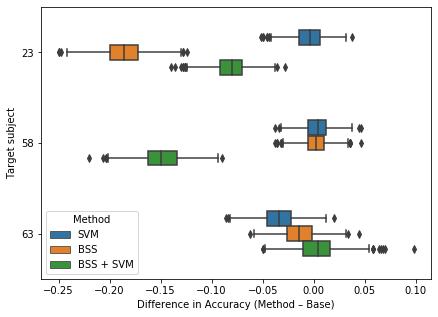

In [58]:
plt.figure(figsize=(7, 5))
sns.boxplot(data = total, x = 'acc', y = 'subj', hue = 'n_dom', orient='h', width=0.5)
plt.xlabel('Difference in Accuracy (Method – Base)')
# plt.title('Distribution of the differences in accuracy on the \n test set')
plt.legend(title='Method')
plt.ylabel("Target subject");

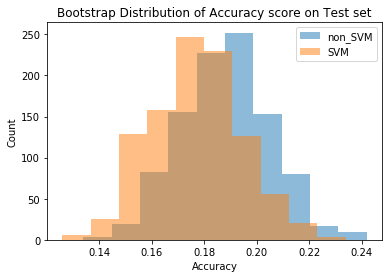

In [80]:
plt.title("Bootstrap Distribution of Accuracy score on Test set")
plt.hist(h2_test_score, alpha=0.5, label = 'non_SVM')
plt.hist(h1_test_score, alpha=0.5, label = 'SVM')
plt.legend()
plt.xlabel("Accuracy")
plt.ylabel("Count");